# Web Scraping and Introductory Data Analysis
bla bla bla

## Part 1: Web Scraping 

In [177]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


In [178]:
WEB_URL = "https://etherscan.io/txs"
TRX_TABLE_XPATH_HEAD = "//table[@class='table table-hover table-align-middle mb-0']/thead/tr/th"
TRX_TABLE_XPATH_BODY = "//table[@class='table table-hover table-align-middle mb-0']/tbody/tr"
ETHER_SCAN_CSV_FILE = "etherscan.csv"
NUM_OF_BLOCKS = 10


We begin by initializing a WebDriver using Selenium. Specifically, we use the Firefox WebDriver to instantiate a Firefox browser instance. This WebDriver will facilitate interactions with web elements. The WebDriver navigates to the [Etherscan.io](https://etherscan.io/txs).  
An assertion is used to verify that the title of the webpage contains the keyword "Ethereum". This step ensures that the WebDriver successfully loaded the expected webpage.  
Also it is good to mention that the webdriver will wait for a page to load by default via .get() method before attempting to scrape the data.

In [179]:
driver = webdriver.Firefox()
def setupWebDriver():
    driver.get(WEB_URL)
    assert "Ethereum" in driver.title

setupWebDriver()

The getTrxTableHeaders function extracts transactions table headers from HTML source code using the table's id. It modifies the extracted headers to match a specific format and returns the modified header as a list.  
The getTrxTableBody function extracts the body of a transaction table from HTML source code using Beautiful Soup. It iterates through each row of the table, extracts the text from each cell, removes newline characters. Additionally, it captures the block number from the first row of the table. 

In [180]:
def getTrxTableHeaders(html_src):
    trx_table_head = html_src.find(id = "ContentPlaceHolder1_theadAllTransactionTable").find_all('th')
    header = [header.get_text().replace("\n", "") for header in trx_table_head]
    header[2] = "Method"
    header.pop(0)
    header.pop(5)
    header.insert(3, "Date")
    header.insert(5, "Local Time")
    header.append("Gas Price")
    return header

def getTrxTableBody(rows_elements, html_src):
    trx_table_body = html_src.find('table')
    trx_table_body = trx_table_body.find_all('tr')
    block_number = 0
    for i in range(1, len(trx_table_body)):
        rows = trx_table_body[i].find_all('td')
        element = [elem.get_text() for elem in rows]
        element = list(map(lambda x: x.replace("\n", ""), element))
        element.pop(8)
        element.pop(0)
        if i == 1:
            block_number = int(element[2])
        rows_elements.append(element)
    return rows_elements, block_number

In this part we iterate through the transaction table, continuously fetching data until a certain condition is met. We click on the "Next" button in order to implement pagination handling to navigate through the pages and collect the last 10 blocks' transactions data. In this case that certain condition is the block number; At each iteration we get the first row's block number and compare it to the latest block number that we have.  
In the end we save the data into a DataFrame.

In [181]:
def saveTransactionsToDp(header, body):
    transactionsDf = pd.DataFrame(body, columns=header)
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, mode='a', header=False, index=False)
    return transactionsDf
    
def scrapeWebPage():
    html_src = BeautifulSoup(driver.page_source, 'html.parser')
    header = getTrxTableHeaders(html_src)
    rows_elements = []
    body, latest_block_number = getTrxTableBody(rows_elements, html_src)
    while True:
        html_src = BeautifulSoup(driver.page_source, 'html.parser')
        body, block_number = getTrxTableBody(body, html_src)
        next_button = driver.find_element(By.XPATH, '//a[@aria-label="Next"]')
        next_button.click()
        if block_number == latest_block_number - NUM_OF_BLOCKS:
            break
    transactionsDf = saveTransactionsToDp(header, body)
    driver.close()
    return latest_block_number, transactionsDf


In [182]:
latest_block_number, transactionsDf = scrapeWebPage()
def saveToCsvFile(transactionsDf):
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, index=False)
    
saveToCsvFile(transactionsDf)

## Part 2: Data Analysis

#### Clean Transactions Data

In [183]:
transactionsDf_raw = transactionsDf.copy()

In [184]:
display(transactionsDf)

,Txn Hash,Method,Block,Date,Age,Local Time,From,To,Value,Txn Fee,Gas Price
0,0x667042892803d820ef3edb83d9f3a0ca0637cff9969a...,Transfer,19398297,2024-03-09 15:00:23,4 secs ago,1709996423,beaverbuild,0xF135B9eD...89049bd79,0.031156357 ETH,0.0013321,63.43375698
1,0xbc523896c39e0054e82a294aaa71c0ead710f49bd337...,Transfer,19398297,2024-03-09 15:00:23,4 secs ago,1709996423,Transak: Wallet 1,0x0AD14226...0c0F2e2E0,0.008695548 ETH,0.00133212,63.43475698
2,0x1bc206ab9f5e016de993e396099571c0ddafcc9e4673...,Transfer,19398297,2024-03-09 15:00:23,4 secs ago,1709996423,0xd1c89bAF...754FEc426,0xDdB8498a...5fFb76159,0.039480383 ETH,0.00133212,63.43475698
3,0xc201d6d69a90088efee7d5b48021c0fdc813c9b02d8a...,Transfer,19398297,2024-03-09 15:00:23,4 secs ago,1709996423,0x1d86655B...9C1b1e589,0x783efab7...1997065F6,6.981832891 ETH,0.00133212,63.43475698
4,0xb787a4b4d07bfa4bf879e89fb935032a471901ed746d...,Transfer,19398297,2024-03-09 15:00:23,4 secs ago,1709996423,0xCDb66857...119179c3c,0xC513bb79...60DA63214,0.051047429 ETH,0.00133212,63.43475698
...,...,...,...,...,...,...,...,...,...,...,...
2645,0x0e3fd444f10d44e6d3f6c7a999d3f558c84b6539fb7d...,Transfer,19398287,2024-03-09 14:58:23,2 mins ago,1709996303,0x685b89B2...8089eA699,0xfb82Fe18...731B243C4,0.097546946 ETH,0.00125309,59.67122428
2646,0x56ab4a3842fbf0fd5b3b74b88cc3a25c7e2429774c07...,Approve,19398287,2024-03-09 14:58:23,2 mins ago,1709996303,0x5bb6C459...A2b330561,0x61457703...DD65d105a,0 ETH,0.00309571,59.92122428
2647,0xbe8da418c52cf0761178e15e09e1482b7999e38908cb...,Transfer,19398287,2024-03-09 14:58:23,2 mins ago,1709996303,SideShift: Hot Wallet,Tether: USDT Stablecoin,0 ETH,0.00276362,59.92122428
2648,0x5c3bdd3ade0c5329345ba513771bb209ce81ba4f5353...,Request L2Transa...,19398287,2024-03-09 14:58:23,2 mins ago,1709996303,0x431284F7...FEE4E47A7,zkSync Era: Diamond Proxy,4.74151516 ETH,0.00637178,59.92122428


In [185]:
transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2650 entries, 0 to 2649
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Txn Hash    2650 non-null   object
 1   Method      2650 non-null   object
 2   Block       2650 non-null   object
 3   Date        2650 non-null   object
 4   Age         2650 non-null   object
 5   Local Time  2650 non-null   object
 6   From        2650 non-null   object
 7   To          2650 non-null   object
 8   Value       2650 non-null   object
 9   Txn Fee     2650 non-null   object
 10  Gas Price   2650 non-null   object
dtypes: object(11)
memory usage: 227.9+ KB


In [186]:
print(f"Rows count before removing duplicate rows: {transactionsDf.shape[0]}")
transactionsDf.drop_duplicates(subset=['Txn Hash'], inplace=True)
print(f"Rows count after removing duplicate rows: {transactionsDf.shape[0]}")

transactionsDf_removed_dups = transactionsDf.copy()

Rows count before removing duplicate rows: 2650
Rows count after removing duplicate rows: 2045


In [187]:
transactionsDf.drop(columns=['Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price'], inplace=True)

transactionsDf['Block'] = transactionsDf['Block'].astype(int)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].astype(float)
transactionsDf['Value'] = transactionsDf['Value'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Value'] = transactionsDf['Value'].apply(lambda x: float(x.split(' ')[0]) if 'ETH' in x else float(x.split(' ')[0])/10**18)

transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2045 entries, 0 to 2649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  2045 non-null   object 
 1   Method    2045 non-null   object 
 2   Block     2045 non-null   int32  
 3   Value     2045 non-null   float64
 4   Txn Fee   2045 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 87.9+ KB


In [188]:
print("Before removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

block_mask = (transactionsDf['Block'] > latest_block_number - NUM_OF_BLOCKS) & (transactionsDf['Block'] <= latest_block_number)
transactionsDf = transactionsDf[block_mask]

print("\nAfter removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

Before removing Extra Blocks:
Max Block number: 19398297, Min Block number:  19398287
Unique Values in Block Column: 11

After removing Extra Blocks:
Max Block number: 19398297, Min Block number:  19398288
Unique Values in Block Column: 10


In [189]:
transactionsDf_cleansed = transactionsDf.copy()

In [190]:
transactionsDf_with_zero_txn = transactionsDf.copy()
display(transactionsDf_with_zero_txn.describe())

transactionsDf_without_zero_txn = transactionsDf[transactionsDf['Value'] > 0]
display(transactionsDf_without_zero_txn.describe())

,Block,Value,Txn Fee
count,1.967000e+03,1967.000000,1967.000000
mean,1.939829e+07,1.435037,0.005311
std,3.124831e+00,21.475003,0.010135
min,1.939829e+07,0.000000,0.001237
25%,1.939829e+07,0.000000,0.001428
50%,1.939829e+07,0.000000,0.002738
75%,1.939830e+07,0.042004,0.005962
max,1.939830e+07,717.929529,0.193762


,Block,Value,Txn Fee
count,8.590000e+02,8.590000e+02,859.000000
mean,1.939829e+07,3.286051e+00,0.004846
std,3.080505e+00,3.241353e+01,0.011257
min,1.939829e+07,7.700000e-17,0.001237
25%,1.939829e+07,1.773051e-02,0.001309
50%,1.939829e+07,5.870454e-02,0.001375
75%,1.939830e+07,2.380624e-01,0.007649
max,1.939830e+07,7.179295e+02,0.193762


### Plotting Histogram of Tnx Fee and Value with and without zero transactions

Transaction Fee Distribution

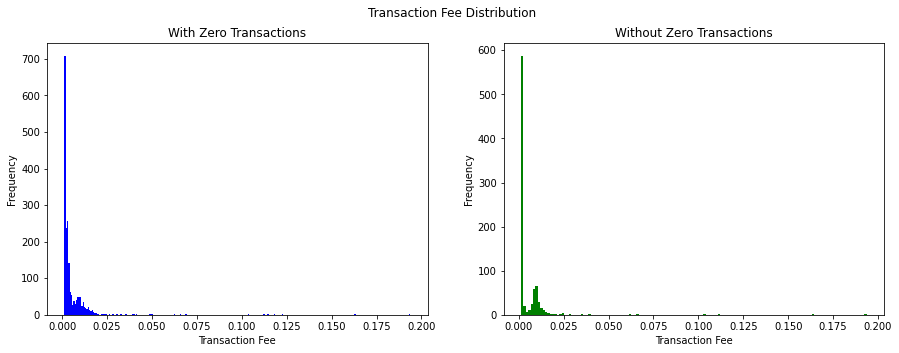

In [191]:
# 3.5 * standard deviation * n^(-1/3)
# bin_width_with_zero_txn = (3.5 * transactionsDf_with_zero_txn['Txn Fee'].std()) / (transactionsDf_with_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)

# bin_width_without_zero_txn = (3.5 * transactionsDf_without_zero_txn['Txn Fee'].std()) / (transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

# #square root of the number of transactions
# bin_size_with_zero_txn = int(transactionsDf_with_zero_txn['Txn Fee'].count()** (1/2))
# bin_size_without_zero_txn = int(transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/2))

# 2 * IQR * n^(-1/3)
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()


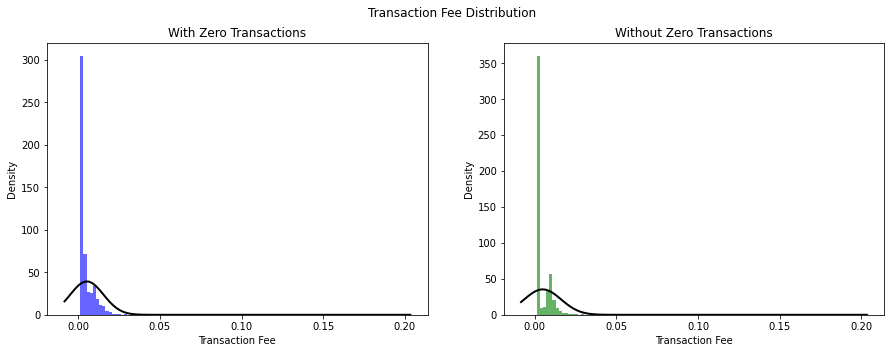

In [192]:

# 1 + log2(n) is the optimal number of bins
# bin_size_with_zero_txn = 1 + int(np.log2(transactionsDf_with_zero_txn['Txn Fee'].count()))
# bin_size_without_zero_txn = 1 + int(np.log2(transactionsDf_without_zero_txn['Txn Fee'].count()))

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle('Transaction Fee Distribution')

# ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
# ax[0].set_title('With Zero Transactions')
# ax[0].set_xlabel('Transaction Fee')
# ax[0].set_ylabel('Frequency')

# ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
# ax[1].set_title('Without Zero Transactions')
# ax[1].set_xlabel('Transaction Fee')
# ax[1].set_ylabel('Frequency')

# plt.show()

# 1 + log2(n) is the optimal number of bins
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

if bin_size_with_zero_txn > 50:
    bin_size_with_zero_txn = 100
if bin_size_without_zero_txn > 50:
    bin_size_without_zero_txn = 100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(transactionsDf_with_zero_txn['Txn Fee'])
mu2, std2 = norm.fit(transactionsDf_without_zero_txn['Txn Fee'])

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

plt.show()

#### Plotting the Histogram of transaction fee using log transformation

In [193]:
def calcBinSize(df):
    bin_width = 2 * (df.quantile(0.75) - df.quantile(0.25)) * df.count() ** (-1/3)
    bin_size = round((df.max() - df.min()) / bin_width)
    if bin_size > 50:
        bin_size = 100
    return bin_size

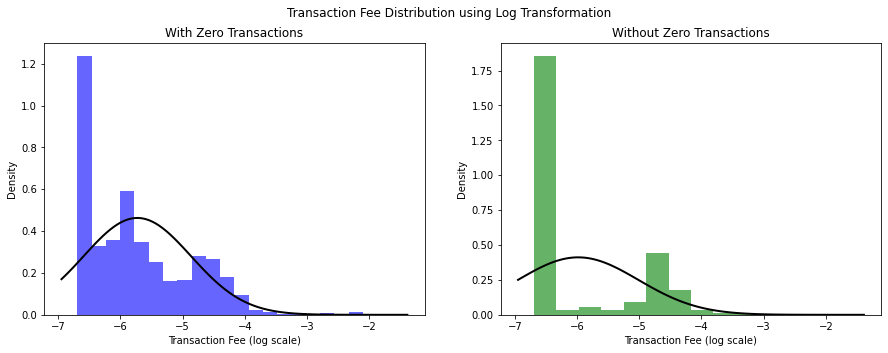

In [194]:
bin_size_with_zero_txn = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Txn Fee']))
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Txn Fee']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(transactionsDf_with_zero_txn['Txn Fee']))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Txn Fee']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee (log scale)')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee (log scale)')
ax[1].set_ylabel('Density')

plt.show()

Transaction Value Distribution

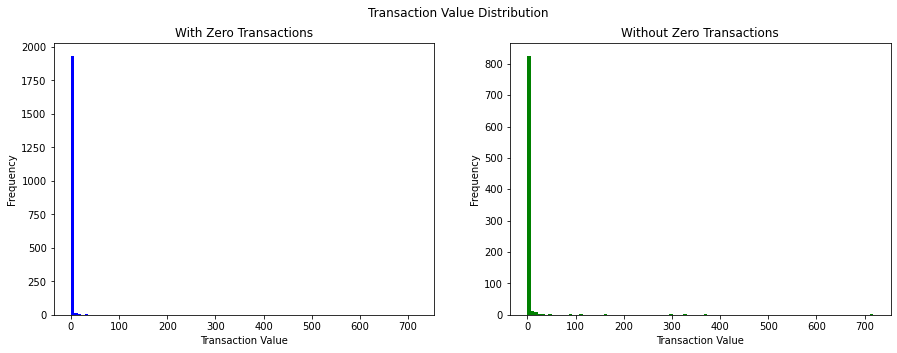

In [195]:

bin_size_with_zero_txn = calcBinSize(transactionsDf_with_zero_txn['Value'])
bin_size_without_zero_txn = calcBinSize(transactionsDf_without_zero_txn['Value'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Value'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Value'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Frequency')

plt.show()

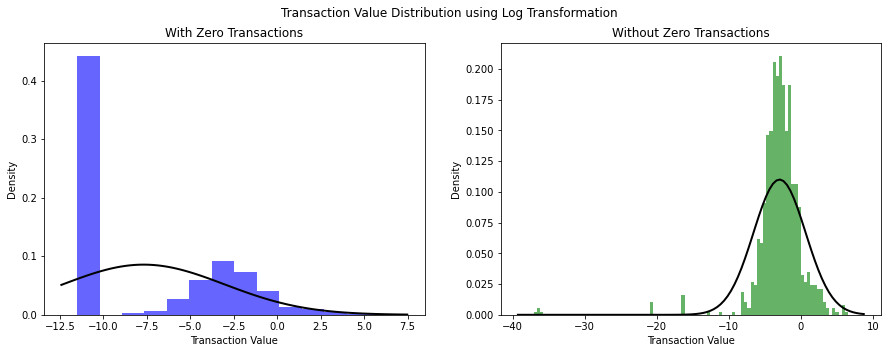

In [196]:
epsilon = 1e-5
tnx_with_epsilon_as_zero = transactionsDf_with_zero_txn['Value'] + epsilon
bin_size_with_zero_txn = calcBinSize(np.log(tnx_with_epsilon_as_zero))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Value']))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

ax[0].hist(np.log(tnx_with_epsilon_as_zero), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Value']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(tnx_with_epsilon_as_zero))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Value']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

plt.show()

### Box Plot

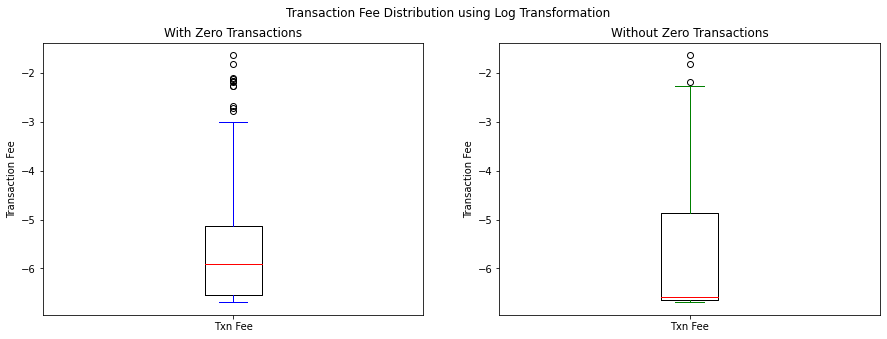

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Txn Fee'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Txn Fee']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Txn Fee'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

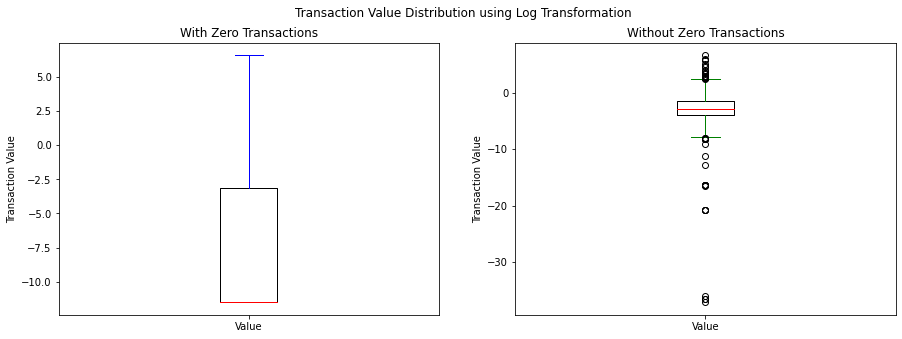

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(tnx_with_epsilon_as_zero))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Value']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

### Violin Plot

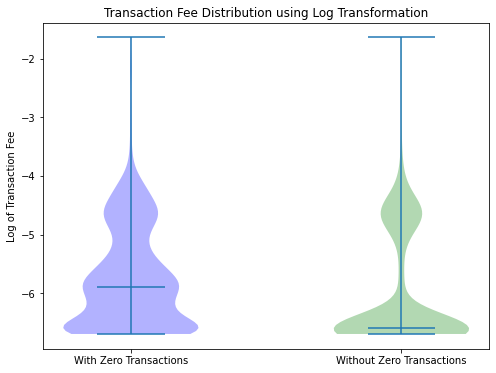

In [199]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(transactionsDf_without_zero_txn['Txn Fee'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()


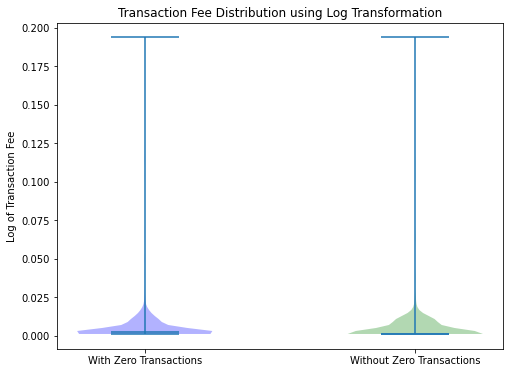

In [200]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Txn Fee'], transactionsDf_without_zero_txn['Txn Fee']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

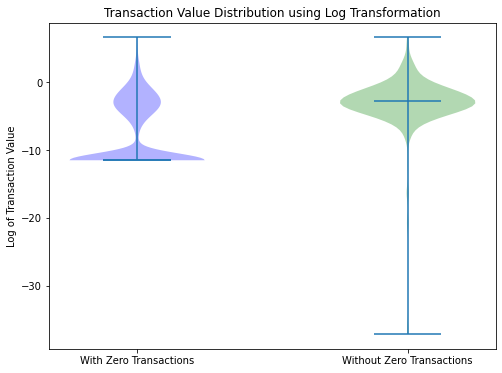

In [201]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(tnx_with_epsilon_as_zero), np.log(transactionsDf_without_zero_txn['Value'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

[Text(1, 0, 'With Zero Transactions'), Text(2, 0, 'Without Zero Transactions')]

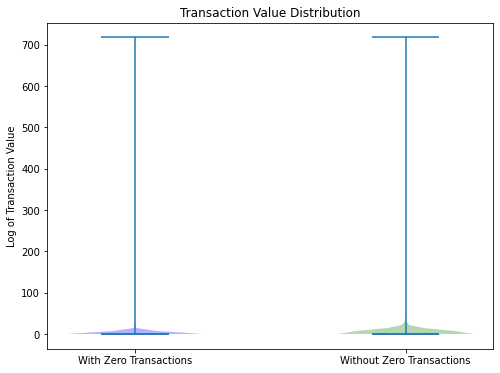

In [202]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Value'], transactionsDf_without_zero_txn['Value']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

## Sampling Data

### Simple Random Sampling (SRS) 

In [203]:
def calcSampleProportion(df):
    z_score = 1.96
    margin_error = 0.05
    std_dev = df['Txn Fee'].std()
    numerator = ((z_score ** 2) * (std_dev * (1-std_dev))) / (margin_error ** 2)
    denominator = 1 + (((z_score ** 2) * (std_dev * (1-std_dev))) / ((margin_error ** 2) * (df.shape[0])))
    n = int(numerator / denominator)
    return max(n/df.shape[0], 0.1)

calcSampleProportion(transactionsDf_without_zero_txn)

0.1

In [204]:
transactionsDf_with_zero_txn[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,1967.000000,1967.000000
mean,1.435037,0.005311
std,21.475003,0.010135
min,0.000000,0.001237
25%,0.000000,0.001428
50%,0.000000,0.002738
75%,0.042004,0.005962
max,717.929529,0.193762


In [205]:
sample_size = round(calcSampleProportion(transactionsDf_with_zero_txn) * transactionsDf_with_zero_txn.shape[0])
simple_random_sampled = transactionsDf_with_zero_txn.sample(n=sample_size, random_state=42)
display(simple_random_sampled[['Value', 'Txn Fee']].describe())

,Value,Txn Fee
count,197.000000,197.000000
mean,1.325939,0.004760
std,10.251451,0.005044
min,0.000000,0.001237
25%,0.000000,0.001363
50%,0.001027,0.002646
75%,0.062303,0.006539
max,112.662428,0.028676


In [206]:
stratified_sampled = pd.DataFrame()

for method, group in transactionsDf_with_zero_txn.groupby('Block'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled = pd.concat([stratified_sampled, sampled_group])

stratified_sampled[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,195.000000,195.000000
mean,0.667956,0.005965
std,4.269670,0.012240
min,0.000000,0.001237
25%,0.000000,0.001374
50%,0.001000,0.002392
75%,0.051880,0.007065
max,44.980000,0.114601


In [207]:
transactionsDf_with_zero_txn['New Methods'] = transactionsDf_with_zero_txn['Method']
transactionsDf_with_zero_txn

,Txn Hash,Method,Block,Value,Txn Fee,New Methods
0,0x667042892803d820ef3edb83d9f3a0ca0637cff9969a...,Transfer,19398297,0.031156,0.001332,Transfer
1,0xbc523896c39e0054e82a294aaa71c0ead710f49bd337...,Transfer,19398297,0.008696,0.001332,Transfer
2,0x1bc206ab9f5e016de993e396099571c0ddafcc9e4673...,Transfer,19398297,0.039480,0.001332,Transfer
3,0xc201d6d69a90088efee7d5b48021c0fdc813c9b02d8a...,Transfer,19398297,6.981833,0.001332,Transfer
4,0xb787a4b4d07bfa4bf879e89fb935032a471901ed746d...,Transfer,19398297,0.051047,0.001332,Transfer
...,...,...,...,...,...,...
2567,0xe3c1491286d2ad949facc1c40874db129d2b90af4a06...,Execute F Fs Yo,19398288,0.000000,0.007369,Execute F Fs Yo
2568,0x4fb321da04f03e67a44f7aabacc03a4d889fea02617f...,0x6e20b107,19398288,0.050000,0.011279,0x6e20b107
2569,0x67dfffaf70c88d63c241a32ac9b8347c1afcbe658dc5...,0x8f4b3430,19398288,0.003670,0.008015,0x8f4b3430
2570,0x247468707d95f5010ecdb417c43a26da19f868394f22...,Fill Quote Eth T...,19398288,0.050821,0.009179,Fill Quote Eth T...


In [208]:
stratified_sampled = pd.DataFrame()

top_9_methods = transactionsDf_with_zero_txn['New Methods'].value_counts().nlargest(9).index
transactionsDf_with_zero_txn.loc[~transactionsDf_with_zero_txn['New Methods'].isin(top_9_methods), 'New Methods'] = 'Other'

for method, group in transactionsDf_with_zero_txn.groupby('New Methods'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled = pd.concat([stratified_sampled, sampled_group])

stratified_sampled[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,197.000000,197.000000
mean,0.633969,0.004701
std,3.058277,0.005616
min,0.000000,0.001237
25%,0.000000,0.001480
50%,0.000000,0.002641
75%,0.025600,0.005828
max,20.000000,0.049886


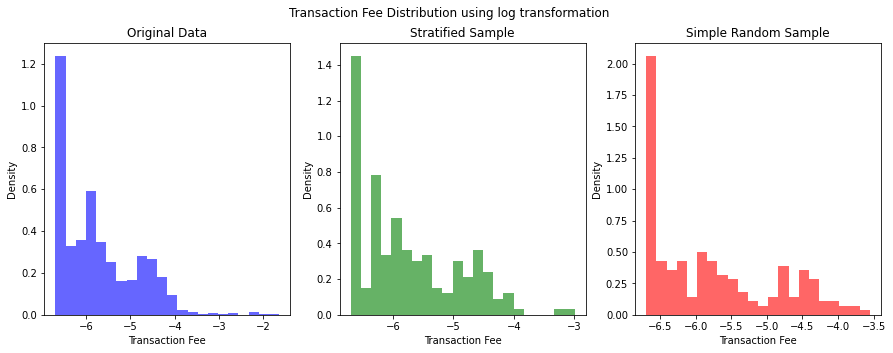

In [209]:
# bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
# bin_size_stratified = calcBinSize(np.log(stratified_sampled['Txn Fee']))
# bin_size_simple = calcBinSize(np.log(simple_random_sampled['Txn Fee']))

bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled['Txn Fee']), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled['Txn Fee']), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Fee')
ax[2].set_ylabel('Density')

plt.show()

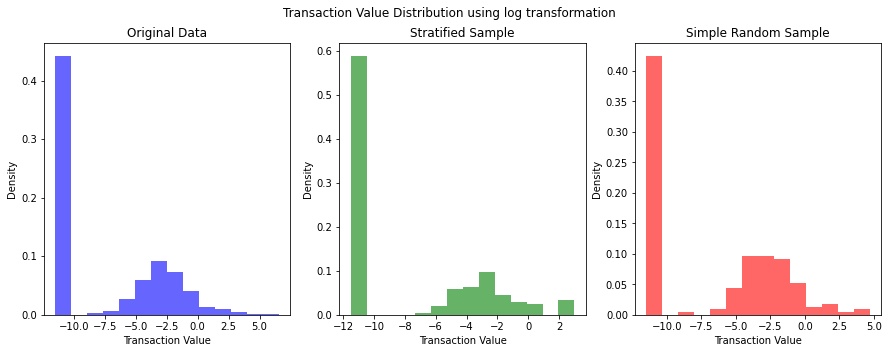

In [210]:
stratified_sampled_plus_epsilon = stratified_sampled['Value'] + epsilon
transactionsDf_with_zero_txn_plus_epsilon = transactionsDf_with_zero_txn['Value'] + epsilon
simple_random_sampled_plus_epsilon = simple_random_sampled['Value'] + epsilon

# bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn_plus_epsilon))
# bin_size_stratified = calcBinSize(np.log(stratified_sampled_plus_epsilon))
# bin_size_simple = calcBinSize(np.log(simple_random_sampled_plus_epsilon))

bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn_plus_epsilon))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn_plus_epsilon), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled_plus_epsilon), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled_plus_epsilon), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Value')
ax[2].set_ylabel('Density')

plt.show()

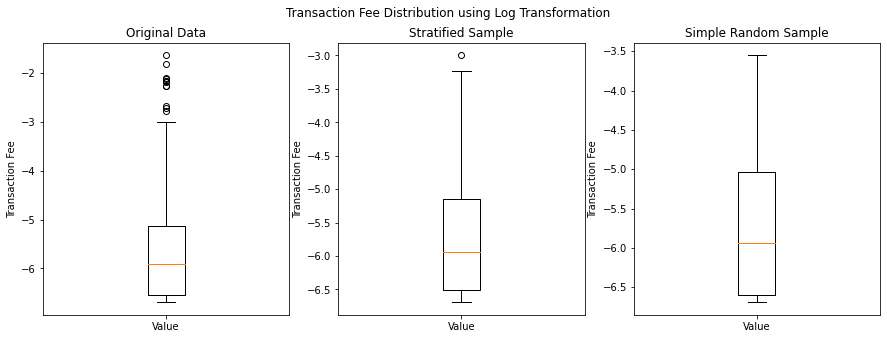

In [211]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled['Txn Fee']))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled['Txn Fee']))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Fee')
ax[2].set_xticklabels(['Value'])

plt.show()

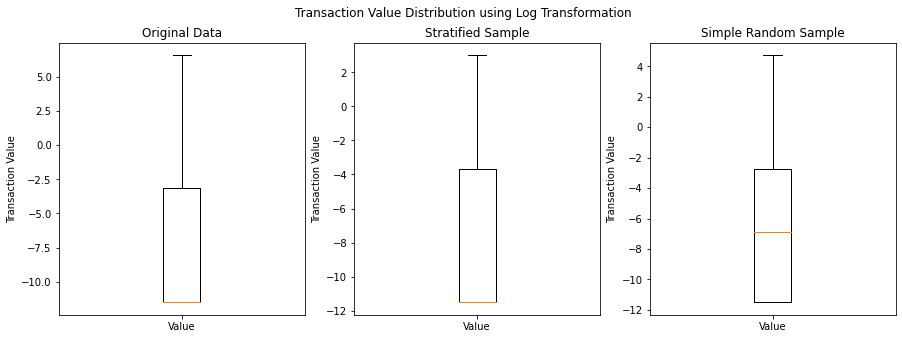

In [212]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn_plus_epsilon))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled_plus_epsilon))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled_plus_epsilon))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Value')
ax[2].set_xticklabels(['Value'])

plt.show()

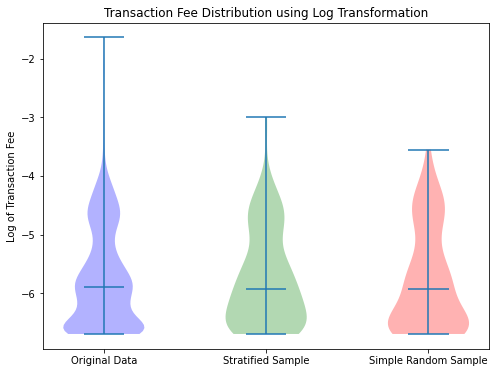

In [213]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(stratified_sampled['Txn Fee']), np.log(simple_random_sampled['Txn Fee'])], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

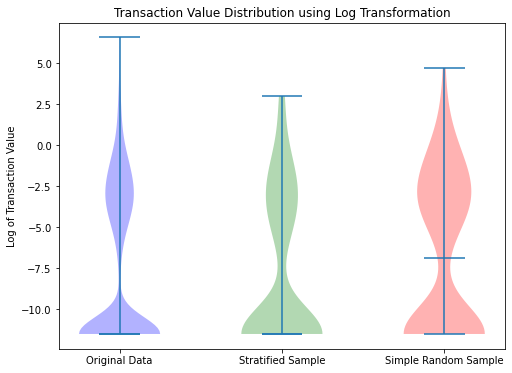

In [214]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn_plus_epsilon), np.log(stratified_sampled_plus_epsilon), np.log(simple_random_sampled_plus_epsilon)], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()